In [1]:
from __future__ import print_function



In [2]:
"""DVS128 closed loop oscillator routine by Alexander Rivkind, Eldad Assa, Michael Kreiserman and Ehud Ahissar
based on: 
*DVS example by: Yuhuang Hu (duguyue100@gmail.com)
*"Syclop" paradigm: Ahissar and Assa 2016
"""
import numpy as np
import time
import SYCLOP_env as syc
import matplotlib.pyplot as plt


import pickle
from RL_brain_b import DeepQNetwork

import cv2
import copy
from misc import *
import maestro
import sys
import os
from pyaer.dvs128 import DVS128
%matplotlib notebook

In [3]:
class Free_run_agent():
    def __init__(self,max_q = None):
        self.hp = HP()
#         self.hp.action_space = ['v_right','v_left','v_up','v_down','null'] + \
#                                [['v_right','v_up'],['v_right','v_down'],['v_left','v_up'],['v_left','v_down']]#
        self.hp.action_space = ['v_right','v_left','null']
        self.hp.max_speed  = 10
        self.q_centre = np.array([0.,0.], dtype='f') 
        self.reset()

    def reset(self):
        self.q_ana = np.array([0.,0.], dtype='f') 
        self.qdot = np.array([0.0,0.0])
        self.qdotdot = np.array([0.0,0.0])
        self.q = np.int32(np.floor(self.q_ana))

    def sync_with_servo(self,servo,orientations = [0,1]):
        for orientation in orientations:
            if not servo.isMoving(orientation):
                self.qdot[orientation]=0.0
                
            
    def act(self,a):
        if a is None:
            action = 'null'
        else:
            action = self.hp.action_space[a]
        #delta_a = 0.001
        if type(action) == list:
            for subaction in action:
                self.parse_action(subaction)
        else:
            self.parse_action(action)

        #print('debug', self.max_q, self.q_centre)
        self.qdot += self.qdotdot
        #self.qdot -= self.hp.returning_force*(self.q_ana-self.q_centre)
        self.q_ana +=self.qdot
        self.q = np.int32(np.floor(self.q_ana))

    def parse_action(self,action):
        if type(action)==int:
            self.qdot[0] = action
            self.qdotdot = np.array([0., 0.])
        elif action == 'v_up':   # up
            self.qdot[1] = self.qdot[1] + (1 if self.qdot[1] < self.hp.max_speed else 0)
            self.qdotdot = np.array([0., 0.])
        elif action == 'v_down':   # down
            self.qdot[1] = self.qdot[1] - (1 if self.qdot[1] > -self.hp.max_speed else 0)  
            self.qdotdot = np.array([0., 0.])
        elif action == 'v_left':   # left
            self.qdot[0] = self.qdot[0] - (1 if self.qdot[0] > -self.hp.max_speed else 0)  
            self.qdotdot = np.array([0., 0.])
        elif action == 'v_right':   # right
            self.qdot[0] = self.qdot[0] + (1 if self.qdot[0] < self.hp.max_speed else 0) 
            self.qdotdot = np.array([0.,0.])
        elif action == 'null':   # null
            pass
        else:
            error('unknown action')

In [4]:
import pickle

In [5]:
    hp = HP()
    hp.mem_depth=1
    hp.logmode = False
    hp.steps_between_learnings = 100
    hp.save_path = 'saved_runs'
    hp.this_run_name = sys.argv[0] + '_noname_' + str(int(time.time()))
    hp.description = "real life syclop 1D metered delays of 0.1s"
    hp.mem_depth = 1
    hp.max_episode =  10000
    hp.steps_per_episode = 1000
    hp.steps_between_learnings = 100
    hp.fading_mem = 0.5
    recorder_file = 'records.pkl'
    hp_file = 'hp.pkl'
    hp.contrast_range = [1.0,1.1]
    hp.logmode = False
    hp.dt_nom=0.025
#     recorder = Recorder(n=4)




    if not os.path.exists(hp.save_path):
        os.makedirs(hp.save_path)

    hp.this_run_path = hp.save_path+'/'+hp.this_run_name+'/'
    if not os.path.exists(hp.this_run_path):
        os.makedirs(hp.this_run_path)
    else:
        error('run name already exists!')


    with open(hp.this_run_path+hp_file, 'wb') as f:
        pickle.dump(hp, f)

    sensor = syc.Sensor()
    agent = Free_run_agent()

    reward = syc.Rewards()
    observation_size = 256*4
    RL = DeepQNetwork(len(agent.hp.action_space), observation_size*hp.mem_depth,#sensor.frame_size+2,
                      reward_decay=0.99,
                      e_greedy=0.95,
                      e_greedy0=0.95,
                      replace_target_iter=10,
                      memory_size=100000,
                      e_greedy_increment=0.0001,
                      learning_rate=0.0025,
                      double_q=False,
                      dqn_mode=True,
                      state_table=np.zeros([1,observation_size*hp.mem_depth])
                      )
#     RL.dqn.load_nwk_param('saved_runs/run_syclop_lirondb.py_noname_1557658952/best_liron.nwk')
#     RL.dqn.load_nwk_param('zhoka.nwk')
#     RL.dqn.load_nwk_param('saved_runs/old_flat_saves/liron_random_ic05.nwk')

In [6]:
servo = maestro.Controller(ttyStr='/dev/ttyACM1')

In [7]:
def gohome():    
    servo.setSpeed(0,0)
    servo.setSpeed(1,0)
    servo.setTarget(1,7500)     #set speed of servo 1
    servo.setTarget(0,5000)  #set servo to move to center position
    servo.setSpeed(0,1)
    servo.setSpeed(1,1)
    time.sleep(1.0)

In [8]:
gohome()

In [9]:
servo.moveByVelocity(0,-1)

In [10]:
def local_observer(sensor,agent):
    if hp.logmode:
        normfactor=1.0
    else:
        normfactor = 1.0/1.0
    return normfactor*np.concatenate([relu_up_and_down(sensor.central_dvs_view),
            relu_up_and_down(cv2.resize(1.0*sensor.dvs_view, dsize=(16, 16), interpolation=cv2.INTER_AREA))])

observation = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
hp.fading_mem = 0.5
recorder = Recorder(n=7)

In [11]:
    with open(hp.this_run_path+hp_file, 'wb') as f:
        pickle.dump(hp, f)

In [12]:
training = True
device = DVS128()


device.start_data_stream()
# load new config
# device.set_bias_from_json("./scripts/configs/dvs128_config.json")
# print (device.get_bias())

clip_value = 3
histrange = [(0, v) for v in (128, 128)]
t_prev = time.time()
dt_nom = hp.dt_nom
episode = 0
# dt_list = []
cnt = 0
empty_cnt = 0
best_thus_far = 0.0
step = 0 
observation = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
observation_ = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
running_ave_reward = 0
agent.reset()
t0 = time.time()
for episode in range(hp.max_episode):
    gohome()
    print('going home!')

    observation = 0*local_observer(sensor, agent)
    observation_ = 0*local_observer(sensor, agent)
    agent.reset()
    step_prime=0
    while step_prime < hp.steps_per_episode:
        t_this = time.time()
        try:
            (pol_events, num_pol_event,
             special_events, num_special_event) = \
                device.get_event("events_hist")
            if t_this - t_prev > dt_nom:
                    t_prev=t_this
                    if num_pol_event != 0:
                        img = pol_events[..., 1]-pol_events[..., 0]
                        cv2.imshow("image", np.flip(np.flip( img/float(clip_value*2),axis=0),axis=1))

                        action = RL.choose_action(observation.reshape([-1]))
                        reward.update_rewards(sensor = sensor, agent = agent)
                        running_ave_reward = 0.999*running_ave_reward+0.001*reward.reward
    #                     reward.update_rewards(sensor = sensor, agent = agent)
                        recorder.record([agent.q_ana[0],agent.q_ana[1], agent.qdot[0],agent.qdot[1],reward.reward,t_this,RL.epsilon])
                        agent.sync_with_servo(servo)
                        agent.act(action)
                        for orientation in [0,1]:
                            servo.moveByVelocity(orientation,(int(np.round(agent.qdot[orientation]))))
                        sensor.dvs_view = cv2.resize(1.0*img, dsize=(64, 64))
                        sensor.central_dvs_view = cv2.resize(1.0*img[64-8:64:8,64-8:64+8], dsize=(16, 16))
                        if step_prime == 0:
                            sensor.dvs_view *= 0.
                            sensor.central_dvs_view *= 0.
    #                     print(np.min(sensor.dvs_view ),np.max(sensor.dvs_view ) )
                        observation_ *= hp.fading_mem
                        observation_ += local_observer(sensor, agent)  # todo: generalize
                        if step%1000 ==0:
                            print('step',step)
                        RL.store_transition(observation.reshape([-1]), action, reward.reward, observation_.reshape([-1]))
                        observation = copy.copy(observation_)
                        step += 1
                        step_prime +=1
                        if  (step > 100) and (step % hp.steps_between_learnings == 0):
                            t_pre=time.time()
                            RL.learn()
                            t_post=time.time()
                            if running_ave_reward > best_thus_far:
                                best_thus_far = running_ave_reward
                                RL.dqn.save_nwk_param(hp.this_run_path+'best_live.nwk')
                                print('saved best network, mean reward: ', best_thus_far)
#                             print('training took', t_post-t_pre)
                        if step%10000 ==0:
                            recorder.plot()
                            RL.dqn.save_nwk_param(hp.this_run_path+'tempX_1.nwk')
                    # debug_policy_plot()
                        if step % 10000 == 0:
                                recorder.save(hp.this_run_path+recorder_file)
                        if step%1000 ==0:
                            print(episode,step,' running reward   ',running_ave_reward)

        except KeyboardInterrupt:
                device.shutdown()
                break
            

going home!
step 0
saved best network, mean reward:  0.0026861425703569607
saved best network, mean reward:  0.007494663477304464
saved best network, mean reward:  0.010539932040432905
saved best network, mean reward:  0.014658173499335575
0 1000  running reward    0.013731119705635312
going home!
step 1000
saved best network, mean reward:  0.017168983921427853
1 2000  running reward    0.01294749566610688
going home!
step 2000
saved best network, mean reward:  0.018862231103193353
saved best network, mean reward:  0.020744801754902953
saved best network, mean reward:  0.026630654051889347
saved best network, mean reward:  0.02947941468262949
2 3000  running reward    0.02677046317803535
going home!
step 3000
saved best network, mean reward:  0.03250277988755146
going home!


TypeError: 'NoneType' object is not iterable

In [ ]:
RL.dqn.save_nwk_param('zhoka25ms.nwk')


In [ ]:
device.shutdown()

In [ ]:
RL.dqn.load_nwk_param('saved_runs//usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py_noname_1558597678/best_live.nwk')

In [ ]:
hp.this_run_path+'best_live.nwk'

In [ ]:
RL.epsilon=0.99

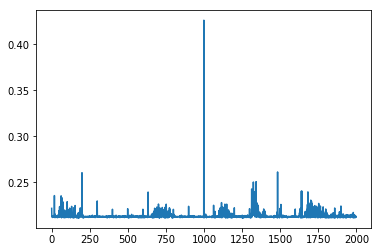

In [14]:
plt.figure()
plt.plot(np.log10(np.diff(recorder.records[-2][:2000])-np.log10(hp.dt_nom)))


In [ ]:
1+1

(0, 10)

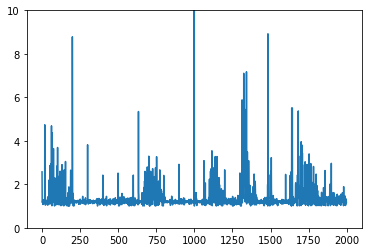

In [19]:
plt.figure()
plt.plot((np.diff(recorder.records[-2][:2000])/(hp.dt_nom)))
plt.ylim([0,10])

(array([1.856e+03, 1.010e+02, 2.500e+01, 6.000e+00, 6.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1.00093842,  2.04048586,  3.0800333 ,  4.11958075,  5.15912819,
         6.19867563,  7.23822308,  8.27777052,  9.31731796, 10.35686541,
        11.39641285, 12.43596029, 13.47550774, 14.51505518, 15.55460262,
        16.59415007, 17.63369751, 18.67324495, 19.7127924 , 20.75233984,
        21.79188728, 22.83143473, 23.87098217, 24.91052961, 25.95007706,
        26.9896245 , 28.02917194, 29.06871939, 30.10826683, 31.14781427,
        32.18736172, 33.22690916, 34.2664566 , 35.30600405, 36.3

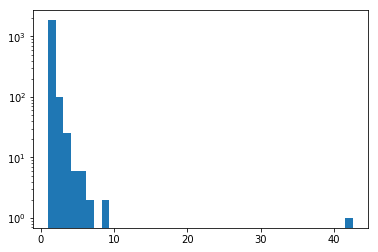

In [22]:
plt.figure()
plt.hist((np.diff(recorder.records[-2][:2000])/(hp.dt_nom)),log=True,bins=40)

In [24]:
uu=Recorder(n=7)

In [25]:
uu.load('saved_runs//usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py_noname_1558603217/')

FileNotFoundError: [Errno 2] No such file or directory: 'saved_runs//usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py_noname_1558603217/recorder_file'